In [1]:
import torch
from torch import nn, Tensor, from_numpy
import torch.nn.functional as F
import torch.optim as optim

from utils import get_data_generator, get_data_tensor
from config import load_config
import numpy as np
import matplotlib.pyplot as plt

import wandb
from tqdm import trange

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
config = load_config()
train_data = get_data_tensor(config)
test_data = get_data_tensor(config, train=False)

In [3]:
# ---------------------------
# Helper blocks
# ---------------------------
class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, downsample: bool = True) -> None:
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2 if downsample else 1, padding=1)
        self.norm = nn.BatchNorm2d(out_channels)
        self.lrelu = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x: Tensor) -> Tensor:
        return self.lrelu(self.norm(self.conv(x)))


class UpConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.norm = nn.BatchNorm2d(out_channels)
        self.lrelu = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x: Tensor) -> Tensor:
        if self.upsample:
            x = self.upsample(x)
        return self.lrelu(self.norm(self.conv(x)))


# ---------------------------
# Residual block for the bottleneck.
# ---------------------------
class ResidualBlock(nn.Module):
    def __init__(self, channels: int) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.norm1 = nn.BatchNorm2d(channels)
        self.lrelu = nn.LeakyReLU(0.2, inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.norm2 = nn.BatchNorm2d(channels)

    def forward(self, x: Tensor) -> Tensor:
        residual = x
        out = self.lrelu(self.norm1(self.conv1(x)))
        out = self.norm2(self.conv2(out))
        return self.lrelu(out + residual)


# ---------------------------
# Generator with configurable layer sizes using hyperparameter "dim_mults"
# ---------------------------
class DDGANGenerator(nn.Module):
    def __init__(self, in_channels: int = 3, base_channels: int = 64, dim_mults: list[int] = [1, 2, 4],
                 num_res_blocks: int = 2) -> None:
        """
        Args:
            in_channels: Number of channels in the input latent (e.g. from autoencoder)
            base_channels: Base number of channels to multiply by each factor in dim_mults
            dim_mults: List of multipliers controlling the number of channels at each encoder stage.
                       For example, [1, 2, 4] creates encoder channels: base_channels, 2*base_channels, 4*base_channels.
            num_res_blocks: Number of residual blocks at the bottleneck.
        """
        super().__init__()
        self.dim_mults = dim_mults

        channels = [in_channels, *(base_channels * mult for mult in dim_mults)]
        encoder_in_out_channels = list(zip(channels, channels[1:]))
        decoder_in_out_channels = map(reversed, reversed(encoder_in_out_channels))

        # Build Encoder dynamically
        self.encoder_blocks = nn.ModuleList()
        
        for current_channels, out_channels in encoder_in_out_channels:
            self.encoder_blocks.append(ConvBlock(current_channels, out_channels, downsample=True))

        # Bottleneck: add residual blocks
        self.res_blocks = nn.Sequential(*[ResidualBlock(channels[-1]) for _ in range(num_res_blocks)])

        # Build Decoder dynamically (reverse order of encoder dims)
        decoder_dims = list(reversed(dim_mults))
        self.decoder_blocks = nn.ModuleList()
        for i, (current_channels, out_channels) in enumerate(decoder_in_out_channels):
            # For the last decoder block, do not upsample.
            self.decoder_blocks.append(UpConvBlock(current_channels, out_channels))

        # Final convolution to produce output with same channels as input
        self.out_conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Input latent (noisy latent code) of shape (N, C, H, W)
            t: Current diffusion timestep (can be used for conditioning)
            noise: Additional noise to inject (for diffusion process)
        Returns:
            Denoised latent representation.
        """
        # Encoder forward pass with saving features for skip connections.
        enc_features: list[Tensor] = []
        for block in self.encoder_blocks:
            enc_features.append(x)
            x = block(x)            

        # Bottleneck
        x = self.res_blocks(x)

        # Decoder forward pass with skip connections (using reversed order)
        enc_features = enc_features[::-1]  # Reverse list for skip connections
        for i, block in enumerate(self.decoder_blocks):
            x = block(x) + enc_features[i]

        # Final output convolution
        x = self.out_conv(x)
        return x


# ---------------------------
# Multi-scale discriminator
# ---------------------------
class Discriminator(nn.Module):
    def __init__(self, in_channels: int = 3, base_channels: int = 64, dim_mults: list[int] = [1, 2, 4]) -> None:
        super().__init__()
        channels = [in_channels, *(base_channels * dim_mult for dim_mult in dim_mults)]
        self.discriminator = nn.Sequential(
            *[
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
                    nn.LeakyReLU(0.2, inplace=True),
                )
                for in_channels, out_channels in zip(channels, channels[1:])
            ],
            nn.Conv2d(channels[-1], 1, kernel_size=4, padding=0),
        )

    def forward(self, imgs: Tensor, noisy_imgs: Tensor) -> Tensor:
        return self.discriminator(torch.cat([imgs, noisy_imgs], dim=1))


# ---------------------------
# Loss functions: Adversarial and Reconstruction
# ---------------------------
def real_loss(logits: Tensor) -> Tensor:
    return F.softplus(-logits).mean()


def fake_loss(logits: Tensor) -> Tensor:
    return F.softplus(logits).mean()


def generator_loss(fake_logits: Tensor) -> Tensor:
    return real_loss(fake_logits)


def discriminator_loss(real_logits: Tensor, fake_logits: Tensor) -> Tensor:
    return 0.5 * (0.9 * real_loss(real_logits) + 0.1 * fake_loss(real_logits) + 0.9 * fake_loss(fake_logits) + 0.1 * fake_loss(fake_logits))


def reconstruction_loss(reconstructed: Tensor, target: Tensor) -> Tensor:
    return F.l1_loss(reconstructed, target)


# ---------------------------
# Noise
# ---------------------------
def add_noise(imgs: Tensor, temp: float) -> Tensor:
    return (real_imgs + temp * torch.randn_like(real_imgs)) / (1 + temp)


# ---------------------------
# Training step example
# ---------------------------
def train_step(
        generator: nn.Module,
        discriminator: nn.Module,
        optimizer_G: torch.optim.Optimizer,
        optimizer_D: torch.optim.Optimizer,
        real_imgs: Tensor,
        temp: float = 1e-2,
) -> tuple[float, float]:
    """
    Args:
        generator: The generator network.
        discriminator: The multi-scale discriminator.
        optimizer_G: Optimizer for the generator.
        optimizer_D: Optimizer for the discriminator.
        real_latents: Real latent codes (from a pretrained autoencoder) of shape (N, C, H, W).
        diffusion_coeff: Coefficient for the forward diffusion process.
        timestep: Current diffusion timestep (conditioning input).
    Returns:
        Tuple containing (generator loss, discriminator loss).
    """
    device = real_imgs.device
    noisy_imgs = add_noise(real_imgs, temp)
    # -----------------
    # Generator update
    # -----------------
    for _ in range(1):
        optimizer_G.zero_grad()
        fake_imgs = generator(noisy_imgs)
        g_loss = generator_loss(discriminator(fake_imgs, noisy_imgs))
        g_loss.backward()
        optimizer_G.step()

    # -----------------
    # Discriminator update
    # -----------------
    optimizer_D.zero_grad()
    d_loss = discriminator_loss(
        discriminator(add_noise(real_imgs, 0), noisy_imgs),
        discriminator(fake_imgs.detach(), noisy_imgs)
    )
    d_loss.backward()
    optimizer_D.step()

    return g_loss.item(), d_loss.item()


In [4]:
device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
in_channels: int = 1
base_channels: int = 64
dim_mults: list[int] = [1, 2, 4, 4]
num_res_blocks: int = 2

# Instantiate models
generator = DDGANGenerator(in_channels, base_channels, dim_mults, num_res_blocks).to(device)
discriminator = Discriminator(2 * in_channels, base_channels, dim_mults[:-2]).to(device)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))
num_steps = 100000

# Data
batch_size = 256
train_data_generator = get_data_generator(train_data, batch_size=batch_size)
temp = 1e-1

wandb.init(project="One-step gan denoiser")

for step in trange(num_steps):
    real_imgs = next(train_data_generator).to(device)
    g_loss, d_loss = train_step(
        generator,
        discriminator,
        optimizer_G,
        optimizer_D,
        real_imgs,
        temp,
    )

    wandb.log({
        "Step": step,
        "G_loss": g_loss,
        "D_loss": d_loss,
    })

    if (step + 1) % 10000 == 0:
        real_imgs = test_data[:10]
        noisy_imgs = add_noise(real_imgs, temp)
        fake_imgs = generator(noisy_imgs.to(device)).detach().cpu()

        fig = plt.figure(figsize=(20, 5))

        for i in range(10):
            plt.subplot(3, 10, i + 1)
            plt.imshow(real_imgs[i, 0])
            plt.axis("off")

            plt.subplot(3, 10, i + 11)
            plt.imshow(noisy_imgs[i, 0])
            plt.axis("off")

            plt.subplot(3, 10, i + 21)
            plt.imshow(fake_imgs[i, 0])
            plt.axis("off")

        wandb.log({"Generated samples": wandb.Image(fig)})
        plt.close(fig)
        # plt.show()

wandb.finish()

wandb: Currently logged in as: antonii-belyshev to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


100%|██████████| 100000/100000 [25:37<00:00, 65.03it/s] 


D_loss,▇▇▇▇▇▇▇▇▇▇▆▆▆▆▅█▆▆▅▅▆▄▅▄▃▄▄▄▄▄▅▃▃▃▂▆▁▄▄▃
G_loss,▃▃▃▂▂▂▂▁▁▄▂▃▂▃▂▂▃▄▁▄▃▃▅▅▃█▅▅▄▃▄▇▃▇▃▃▅▄▄▄
Step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
D_loss,0.54226
G_loss,0.8906
Step,99999


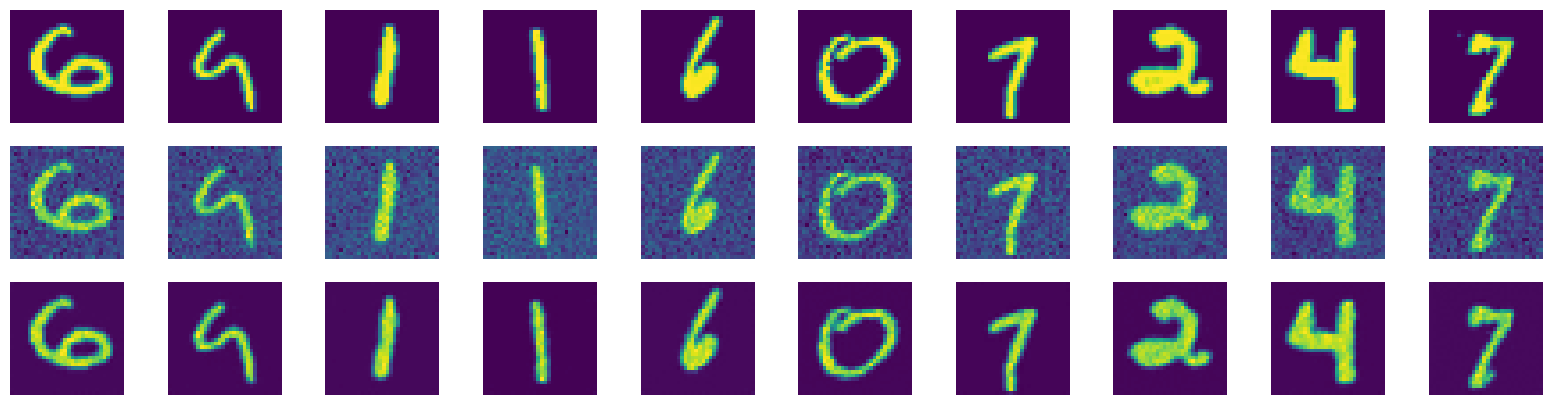

In [5]:
real_imgs = next(train_data_generator)
noisy_imgs = add_noise(real_imgs, temp)
fake_imgs = generator(noisy_imgs.to(device)).detach().cpu()


plt.figure(figsize=(20, 5))

for i in range(10):
    plt.subplot(3, 10, i + 1)
    plt.imshow(real_imgs[i, 0])
    plt.axis("off")
    plt.subplot(3, 10, i + 11)
    plt.imshow(noisy_imgs[i, 0])
    plt.axis("off")
    plt.subplot(3, 10, i + 21)
    plt.imshow(fake_imgs[i, 0])
    plt.axis("off")

In [36]:
diffusion_samples = np.load("results/mnist_50000_iter_flattening_temp_unbiased_schedule_100_steps_samples.npz")
states = from_numpy(diffusion_samples["states"])

In [35]:
diffusion_samples["temp"].reshape(-1)

array([9.60840285e-03, 1.01201683e-01, 1.88313305e-01, 2.73593664e-01,
       3.59325320e-01, 4.46149498e-01, 5.33330500e-01, 6.20493591e-01,
       7.07934082e-01, 7.95311868e-01, 8.82630825e-01, 9.69877481e-01,
       1.05677605e+00, 1.14342391e+00, 1.22993147e+00, 1.31620622e+00,
       1.40257311e+00, 1.48908997e+00, 1.57595360e+00, 1.66282821e+00,
       1.75000298e+00, 1.83763564e+00, 1.92592680e+00, 2.01497364e+00,
       2.10471034e+00, 2.19548273e+00, 2.28735375e+00, 2.38049364e+00,
       2.47493291e+00, 2.57049060e+00, 2.66726208e+00, 2.76549482e+00,
       2.86546898e+00, 2.96721339e+00, 3.07090402e+00, 3.17677307e+00,
       3.28488278e+00, 3.39536738e+00, 3.50842595e+00, 3.62422538e+00,
       3.74306631e+00, 3.86515546e+00, 3.99069262e+00, 4.11983252e+00,
       4.25282097e+00, 4.38984299e+00, 4.53108692e+00, 4.67711210e+00,
       4.82800102e+00, 4.98406172e+00, 5.14568043e+00, 5.31292439e+00,
       5.48621798e+00, 5.66629744e+00, 5.85357761e+00, 6.04876041e+00,
      

In [37]:
x = states[:, 0]

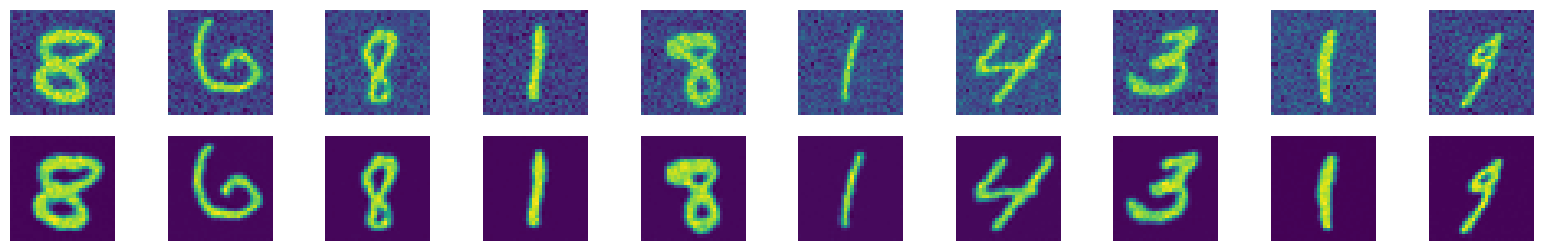

In [38]:
fake_imgs = generator(x.to(device)).detach().cpu()


plt.figure(figsize=(20, 3))

for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(x[i, 0])
    plt.axis("off")
    plt.subplot(2, 10, i + 11)
    plt.imshow(fake_imgs[i, 0])
    plt.axis("off")